## 1. Import libraries

In [ ]:
import pandas as pd
import json
import joblib
import tempfile


import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from common import  trino_connection, trino_connection,  detrend, deseason, scale_minmax, minio_client,\
    inverse_transform, add_season, add_trend
from config import get_selected_items_faostat
from datetime import datetime

In [50]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## 2. Load data

In [ ]:
def load_crop_data(crop_code):
    sql_query = f"""
            SELECT  ff.ProducerPrice_LCU_tonne_LCU_month as Price,
                    fw.Temp, fw.Humidity, fw.Precip, fw.Solarenergy,
                    dd.DateINT,
                    dd.Date,
                    ff.CropCode
            FROM "default".fact_faostat AS ff           
                JOIN (SELECT DateINT,YearMonth, Date 
                        FROM "default".dim_date
                        WHERE Date >= DATE'2011-01-01' 
                            AND Date <= DATE '2023-12-01') AS dd
                    ON dd.DateINT = ff.DateINT
                JOIN (
                        Select dateint, Avg(temp) as temp, Avg(humidity) as humidity, 
                            Avg(precip) as precip, Avg(solarenergy) as solarenergy
                        FROM"default".fact_weather 
                        group by dateint
                    )AS fw
                    ON fw.DateINT = ff.DateINT
            WHERE ProducerPrice_SLC_tonne_SLC_month IS NULL
                AND ff.CropCode = {crop_code}
            ORDER BY dd.YearMonth
        """
    df_pandas = pd.read_sql(sql_query, trino_connection())
    df_pandas.interpolate(method='linear', inplace=True, limit_direction='both')

    
    return df_pandas

## 3. Data Preprocessing
### Detrended data
### Deseasoned
### Standardization MinMax

In [ ]:
def preprocess_data(time_series):
    
    time_series_price = time_series[:, 0]

    time_series_detrended, trend_model = detrend(time_series_price)
    time_series_deseasoned, seasonal_avg =  deseason(time_series_detrended)

    time_series[:, 0] = time_series_deseasoned 

    time_series_scaled, scaler = scale_minmax(time_series)
    return time_series_scaled, trend_model, seasonal_avg, scaler

def preprocess_data_2(data, trend_model, seasonal_avg, scaler, pedict_indx = 0):

    price = data[:, 0]
    price_detrended, _ = detrend(price, trend_model, pedict_indx)
    price_deseasoned, _ = deseason(price_detrended, seasonal_avg)
    data[:, 0] = price_deseasoned  

    data_scaled, _ = scale_minmax(data, scaler)
    return data_scaled

In [ ]:
def repreprocess_data(time_series, trend_model, seasonal_avg, scaler, pedict_indx, prediction_length):
      
    time_series_inversed = inverse_transform(time_series, scaler)

    time_series_addseasoned =  add_season(time_series_inversed[:,0], seasonal_avg)
    time_series_addtrended = add_trend(time_series_addseasoned, trend_model, pedict_indx, prediction_length)
    
    return time_series_addtrended

## 4. Model

In [ ]:
num_rnn_layer_list = [1, 2, 3]
num_lstm_layer_list = [1, 2, 3]
units_list = [32, 64, 128]
sequence_lengths = [6, 12]

features = ["Price", "Temp", "Humidity", "Precip", "Solarenergy"]

### 4.1 RNN

In [ ]:
def build_model_rnn(hp, input_shape):

    model = Sequential()
    num_rnn_layer = hp.Choice(f'num_rnn_layer', num_rnn_layer_list)
    units = hp.Choice(f'units', units_list)
    dropout = 0.1

    model.add(Input(shape=input_shape))
    for i in range(num_rnn_layer):
        return_sequences = (i < num_rnn_layer - 1)

        model.add(SimpleRNN(units, activation='tanh',
                           return_sequences=return_sequences))
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(optimizer=RMSprop(0.001), loss='mse')

    return model

### 4.2 LSTM

In [ ]:
def build_model_lstm(hp, input_shape):

    model = Sequential()
    num_lstm_layer = hp.Choice(f'num_lstm_layer', num_lstm_layer_list)
    units = hp.Choice(f'units', units_list)
    dropout = 0.1

    model.add(Input(shape=input_shape))
    for i in range(num_lstm_layer):
        return_sequences = (i < num_lstm_layer - 1)
        
        model.add(LSTM(units, activation='tanh',
                           return_sequences=return_sequences))
        if dropout > 0:
            model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(optimizer=RMSprop(0.001), loss='mse')
    
    return model

## 5. Tune and Train

In [ ]:
def tune_and_train(time_series, model_type='lstm', crop_code = ''):
    best_result = None
    best_loss = float('inf')
    hp = kt.HyperParameters()
    epochs = hp.Choice('epochs', [100, 200])
    epochs = 200
    build_model = build_model_lstm if model_type == 'lstm' else build_model_rnn
    for seq_len in sequence_lengths:
        print(f"Tuning with seq_len = {seq_len}")

        split_index = int(len(time_series) * 0.8)
        y_train = time_series[:split_index]
        y_val = time_series[split_index:]

        train_gen = TimeseriesGenerator(y_train, y_train[:, 0], length=seq_len, batch_size=16)
        val_gen = TimeseriesGenerator(y_val, y_val[:, 0], length=seq_len, batch_size=16)

        input_shape = (seq_len, len(features))

        tuner = kt.GridSearch(
            hypermodel=lambda hp: build_model(hp, input_shape),
            objective='val_loss',
            max_trials=20,
            executions_per_trial=1,
            directory=f'{model_type}_tuning',
            project_name=f'seq_len_{seq_len}',
            overwrite=True 
        )
        
        tuner.search(train_gen, validation_data=val_gen, epochs=epochs, verbose = 1, batch_size=32)

        best_hp = tuner.get_best_hyperparameters(1)[0]
        best_model = tuner.get_best_models(1)[0]
        val_loss = best_model.evaluate(val_gen, verbose=0)

        print(f"Best loss for seq_len={seq_len}: {val_loss}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_result = best_hp.values
            best_result['seq_len'] = seq_len
            best_result['val_loss'] = val_loss
            

    return best_model, best_result

## 6. Evaluation

In [ ]:
def evaluation_model(crop_code, prediction_length = 60, model_type='lstm'):

    data = load_crop_data(crop_code)
    data_features = data[features].values

    split_index = int(len(data_features) * 0.75)
    
    y_train_origin = data_features[:split_index].copy()
    
    y_train, trend_model, seasonal_avg, scaler= preprocess_data(y_train_origin.copy())

    model, hyperparams = tune_and_train(y_train, model_type=model_type)

    seq_length = hyperparams['seq_len']

    y_val_origin = data_features[split_index-seq_length+1:].copy()
    y_val = preprocess_data_2(y_val_origin.copy(), trend_model, seasonal_avg, scaler, split_index - seq_length+1)
    
    y_val_gen = TimeseriesGenerator(y_val, y_val[:, 0], length=seq_length, batch_size=16)

    predictions = model.predict(y_val_gen, verbose=0)

    predictions = repreprocess_data(predictions, trend_model, seasonal_avg, scaler, split_index, prediction_length)
    y_val = repreprocess_data(y_val, trend_model, seasonal_avg, scaler, split_index-seq_length+1, prediction_length)

    return predictions,  y_val_origin[seq_length:], hyperparams, model


In [ ]:
rnn_predict, actual, rnn_hyperparams, rnn_model  = evaluation_model(687, prediction_length=60, model_type='rnn')

Trial 1 Complete [00h 00m 32s]
val_loss: 0.00014595639368053526

Best val_loss So Far: 0.00014595639368053526
Total elapsed time: 00h 00m 32s
Best loss for seq_len=6: 0.00014595639368053526


In [ ]:
lstm_predict, _ , lstm_hyperparams, lstm_model = evaluation_model(687, prediction_length=60, model_type='lstm')

Trial 1 Complete [00h 00m 37s]
val_loss: 0.0003068092337343842

Best val_loss So Far: 0.0003068092337343842
Total elapsed time: 00h 00m 37s
Best loss for seq_len=6: 0.0003068092337343842


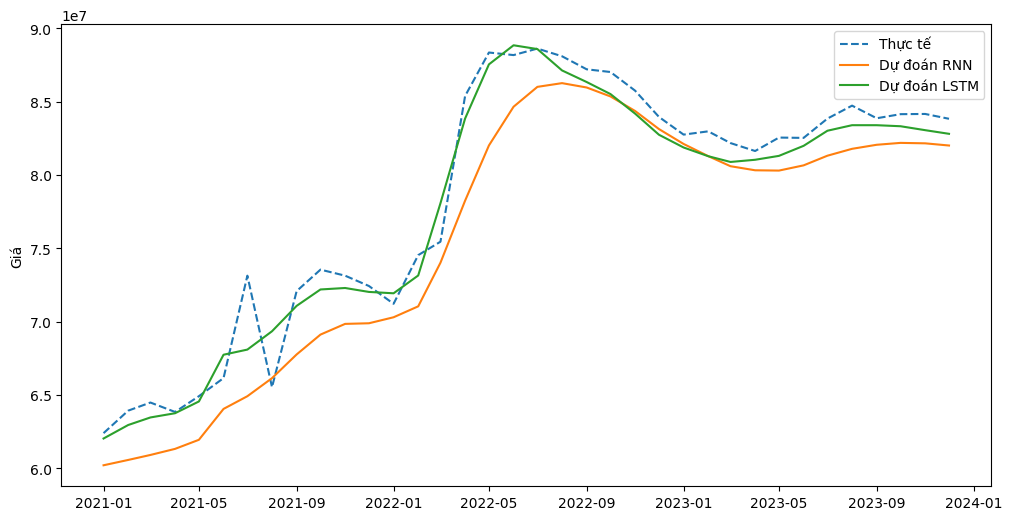

In [224]:
date_range = pd.date_range(start='2021-01', end='2023-12', freq='MS') 
date_array = date_range.to_numpy()

plt.figure(figsize=(12, 6))
plt.plot(date_array, actual[:-2] , label="Thực tế", linestyle='dashed')
plt.plot(date_array, rnn_predict[2:], label="Dự đoán RNN")
plt.plot(date_array, lstm_predict[2:] , label="Dự đoán LSTM")
plt.ylabel("Giá")
plt.legend()
plt.show()  

In [226]:
rnn_mse = mean_squared_error(actual[:-2], rnn_predict[2:])
rnn_rmse = np.sqrt(rnn_mse)
rnn_mae = mean_absolute_error(actual[:-2], rnn_predict[2:])
rnn_r2 = r2_score(actual[:-2], rnn_predict[2:])

lstm_mse = mean_squared_error(actual[:-2], lstm_predict[2:])
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = mean_absolute_error(actual[:-2], lstm_predict[2:])
lstm_r2 = r2_score(actual[:-2], lstm_predict[2:])

df_evaluate = pd.DataFrame({"Evaluation criteria"   : ["MSE", "RMSE", "MAE", "R² Score"],
                            "RNN"                  : [rnn_mse, rnn_rmse, rnn_mae, rnn_r2],
                            "LSTM"                 : [lstm_mse, lstm_rmse, lstm_mae, lstm_r2]})

df_evaluate


,Evaluation criteria,RNN,LSTM
0,MSE,9.815174e+12,2.286151e+12
1,RMSE,3.132918e+06,1.512002e+06
2,MAE,2.637868e+06,1.183255e+06
3,R² Score,8.626101e-01,9.679991e-01


In [ ]:
rnn_model.save(f'..\save_model\crop_{687}_price_rnn_model.h5')
lstm_model.save(f'..\save_model\crop_{687}_price_lstm_model.h5')